# 定义一个简单的神经网络(MNIST数据集)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class MyNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(MyNN,self).__init__()
        self.layer1 = nn.Linear(input_size,hidden_size)
        self.layer2 = nn.Linear(hidden_size,output_size)
        self.dropout = nn.Dropout(0.3)
    def forward(self,x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

In [3]:
input_size = 784
hidden_size = 128
output_size = 10
model = MyNN(input_size,hidden_size,output_size)
print(model)

MyNN(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [4]:
batch_size = 64
rand_input = torch.rand(batch_size,input_size)
output = model(rand_input)
#print(output)
output.shape

torch.Size([64, 10])

In [5]:
loss = nn.CrossEntropyLoss()
lr = 0.001
opt = torch.optim.Adam(model.parameters(),lr)

In [6]:
from torchvision import datasets,transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
test_dataset = datasets.MNIST(root = './data', train = False, transform = transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = 64,shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 64,shuffle = True)

In [7]:
images, labels = next(iter(train_loader))
print('Images shape : ',images.shape)
print('Labels shape : ',labels.shape)

Images shape :  torch.Size([64, 1, 28, 28])
Labels shape :  torch.Size([64])


In [8]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyNN(input_size = 784, hidden_size = 128, output_size = 10).to(device)

True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs = inputs.view(-1,28*28).to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,predicted = outputs.max(1)
        total += outputs.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 1.*correct / total
    return epoch_loss, epoch_acc

In [11]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.view(-1,28*28).to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _,predicted = outputs.max(1)
            total += outputs.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 1.*correct / total
    return epoch_loss, epoch_acc

In [12]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train_loss : {train_loss:.4f}, Train_acc : {train_acc:.4f}")
    print(f"Test_loss : {test_loss:.4f}, Test_acc : {test_acc:.4f}\n")

Epoch 1/10
Train_loss : 0.4477, Train_acc : 0.8663
Test_loss : 0.2149, Test_acc : 0.9380

Epoch 2/10
Train_loss : 0.2511, Train_acc : 0.9250
Test_loss : 0.1812, Test_acc : 0.9460

Epoch 3/10
Train_loss : 0.2079, Train_acc : 0.9376
Test_loss : 0.1366, Test_acc : 0.9577

Epoch 4/10
Train_loss : 0.1824, Train_acc : 0.9456
Test_loss : 0.1208, Test_acc : 0.9640

Epoch 5/10
Train_loss : 0.1678, Train_acc : 0.9484
Test_loss : 0.1061, Test_acc : 0.9665

Epoch 6/10
Train_loss : 0.1589, Train_acc : 0.9513
Test_loss : 0.1106, Test_acc : 0.9667

Epoch 7/10
Train_loss : 0.1494, Train_acc : 0.9542
Test_loss : 0.1046, Test_acc : 0.9691

Epoch 8/10
Train_loss : 0.1457, Train_acc : 0.9546
Test_loss : 0.0960, Test_acc : 0.9704

Epoch 9/10
Train_loss : 0.1383, Train_acc : 0.9570
Test_loss : 0.1013, Test_acc : 0.9708

Epoch 10/10
Train_loss : 0.1340, Train_acc : 0.9595
Test_loss : 0.0941, Test_acc : 0.9721



In [13]:
torch.save(model.state_dict(),"mnist_model_MyNN.pth")

In [14]:
loaded_model = MyNN(input_size = 784, hidden_size = 128, output_size = 10)
loaded_model.load_state_dict(torch.load("mnist_model_MyNN.pth"))
loaded_model.to(device)

MyNN(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [15]:
def predict(model, image, device):
    model.eval()
    image = image.view(-1,28*28).to(device)
    with torch.no_grad():
        output = model(image)
        _,predicted = output.max(1)
    
    return predicted.item()

True Label : 3, Predicted Label : 3


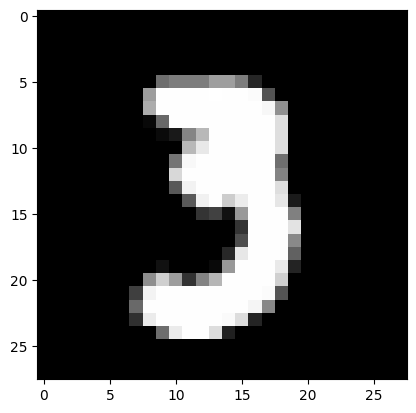

In [17]:
import random
from matplotlib import pyplot
test_image, test_label = test_dataset[random.randint(0,100)]
prediction = predict(loaded_model, test_image, device)
print(f"True Label : {test_label}, Predicted Label : {prediction}")
pyplot.imshow(test_image.reshape((28, 28)), cmap="gray")

# cifar-10 图像分类(简单神经网络 + VGG + ResNet-18)
cifar-10 图像分类与 mnist 数字分类本质上无区别，实现起来代码结构几乎相同。
以下代码改造自 csdn ：[基于 PyTorch 的 cifar-10 图像分类](https://blog.csdn.net/weixin_42570192/article/details/124689392?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522533fba3bf4bdecd45554fd47e3a96d4d%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=533fba3bf4bdecd45554fd47e3a96d4d&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~top_positive~default-1-124689392-null-null.142^v102^pc_search_result_base5&utm_term=cifar-10%E5%9B%BE%E5%83%8F%E5%88%86%E7%B1%BB&spm=1018.2226.3001.4187)

原代码并没有将 model 和 tensor 进行 to(device), 对此进行了一些小修改。使用 ResNet-18 完成 cifar-10 图像分类只需要将 VGG 中的 net 改造为 resnet18 即可

   ## SimpleNet：
   

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import ssl
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time

epoch 1 loss: 2.303
        cost 15.273123 sec
epoch 2 loss: 2.296
        cost 15.121923 sec
epoch 3 loss: 2.231
        cost 14.979549 sec
epoch 4 loss: 2.070
        cost 15.048294 sec
epoch 5 loss: 1.970
        cost 15.015852 sec
epoch 6 loss: 1.815
        cost 15.027612 sec
epoch 7 loss: 1.685
        cost 15.006881 sec
epoch 8 loss: 1.609
        cost 15.180595 sec
epoch 9 loss: 1.550
        cost 15.120375 sec
epoch 10 loss: 1.497
        cost 15.154951 sec
Finished Training


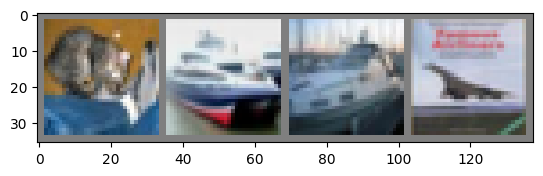

GroundTruth:   cat  ship  ship plane
Predicted:   cat  ship  ship plane
Accuracy of the network on the 10000 test images: 45 %
Accuracy of plane : 45 %
Accuracy of   car : 50 %
Accuracy of  bird : 48 %
Accuracy of   cat : 27 %
Accuracy of  deer : 18 %
Accuracy of   dog : 36 %
Accuracy of  frog : 67 %
Accuracy of horse : 54 %
Accuracy of  ship : 56 %
Accuracy of truck : 57 %


In [19]:
ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_set = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


if __name__ == '__main__':
    epoch_num = 10
    for epoch in range(epoch_num):
        time_start = time.time()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 500 == 499:
                print('epoch %d loss: %.3f' % (epoch + 1, running_loss / 500))
                running_loss = 0.0

        print('        cost %3f sec' % (time.time()-time_start))

    print('Finished Training')

    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct/total))

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))


## VGG：

In [20]:
ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform1 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv7 = nn.Conv2d(128, 128, 1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.conv8 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv10 = nn.Conv2d(256, 256, 1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()

        self.conv11 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, 1, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()

        self.fc14 = nn.Linear(512 * 4 * 4, 1024)
        self.drop1 = nn.Dropout()
        self.fc15 = nn.Linear(1024, 1024)
        self.drop2 = nn.Dropout()
        self.fc16 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.pool4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.pool5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        # print(" x shape ",x.size())
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc14(x))
        x = self.drop1(x)
        x = F.relu(self.fc15(x))
        x = self.drop2(x)
        x = self.fc16(x)

        return x

    def train_sgd(self, device):

        optimizer = optim.SGD(self.parameters(), lr=0.01)
        path = 'weights.tar'
        init_epoch = 0
        loss = nn.CrossEntropyLoss()

        # if os.path.exists(path) is not True:
        #     loss = nn.CrossEntropyLoss()
        # else:
        #     checkpoint = torch.load(path)
        #     self.load_state_dict(checkpoint['model_state_dict'])
        #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #     init_epoch = checkpoint['epoch']
        #     loss = checkpoint['loss']

        epoch_num = 10
        for epoch in range(init_epoch, epoch_num):  # loop over the dataset multiple times
            time_start = time.time()

            running_loss = 0.0
            total = 0
            correct = 0
            for i, (inputs, labels) in enumerate(train_loader, 0):
                # get the inputs
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = self(inputs)
                l = loss(outputs, labels)
                l.backward()
                optimizer.step()

                running_loss += l.item()

                if i % 500 == 499:
                    print('[%d, %5d] loss: %.4f' %
                          (epoch, i, running_loss / 500))
                    running_loss = 0.0
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    print('Accuracy of the network on the %d tran images: %.3f %%' % (total,
                                                                                      100.0 * correct / total))
                    total = 0
                    correct = 0
                    torch.save({'epoch': epoch,
                                'model_state_dict': net.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'loss': loss
                                }, path)

            print('epoch %d cost %3f sec' % (epoch, time.time() - time_start))

        print('Finished Training')

    def test(self, device):
        correct = 0
        total = 0
        with torch.no_grad():
            for (images, labels) in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3f %%' % (100.0 * correct / total))

    def classify(self, device):
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        for (images, labels) in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = self(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i]
                class_total[label] += 1

        for i in range(10):
            print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))


if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = Net()
    net = net.to(device)
    net.train_sgd(device)
    net.test(device)
    net.classify(device)


[0,   499] loss: 1.6328
Accuracy of the network on the 100 tran images: 56.000 %
epoch 0 cost 29.015454 sec
[1,   499] loss: 1.1003
Accuracy of the network on the 100 tran images: 55.000 %
epoch 1 cost 28.651580 sec
[2,   499] loss: 0.8610
Accuracy of the network on the 100 tran images: 74.000 %
epoch 2 cost 28.802603 sec
[3,   499] loss: 0.7273
Accuracy of the network on the 100 tran images: 80.000 %
epoch 3 cost 28.819829 sec
[4,   499] loss: 0.6336
Accuracy of the network on the 100 tran images: 72.000 %
epoch 4 cost 28.860718 sec
[5,   499] loss: 0.5644
Accuracy of the network on the 100 tran images: 82.000 %
epoch 5 cost 29.004982 sec
[6,   499] loss: 0.5092
Accuracy of the network on the 100 tran images: 87.000 %
epoch 6 cost 28.988188 sec
[7,   499] loss: 0.4608
Accuracy of the network on the 100 tran images: 87.000 %
epoch 7 cost 29.037253 sec
[8,   499] loss: 0.4206
Accuracy of the network on the 100 tran images: 86.000 %
epoch 8 cost 29.181368 sec
[9,   499] loss: 0.3798
Accu

## ResNet-18:

In [21]:
ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform1 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# ResNet-18模型
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(Residual, 64, 2)
        self.layer2 = self.make_layer(Residual, 128, 2, stride=2)
        self.layer3 = self.make_layer(Residual, 256, 2, stride=2)
        self.layer4 = self.make_layer(Residual, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def train_sgd(self, device):

        optimizer = optim.SGD(self.parameters(), lr=0.01)
        path = 'weights_resnet.tar'
        init_epoch = 0
        loss = nn.CrossEntropyLoss()

        epoch_num = 10
        for epoch in range(init_epoch, epoch_num):  # loop over the dataset multiple times
            time_start = time.time()

            running_loss = 0.0
            total = 0
            correct = 0
            for i, (inputs, labels) in enumerate(train_loader, 0):
                # get the inputs
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = self(inputs)
                l = loss(outputs, labels)
                l.backward()
                optimizer.step()

                running_loss += l.item()

                if i % 500 == 499:
                    print('[%d, %5d] loss: %.4f' %
                          (epoch, i, running_loss / 500))
                    running_loss = 0.0
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    print('Accuracy of the network on the %d tran images: %.3f %%' % (total,
                                                                                      100.0 * correct / total))
                    total = 0
                    correct = 0
                    torch.save({'epoch': epoch,
                                'model_state_dict': net.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'loss': loss
                                }, path)

            print('epoch %d cost %3f sec' % (epoch, time.time() - time_start))

        print('Finished Training')

    def test(self, device):
        correct = 0
        total = 0
        with torch.no_grad():
            for (images, labels) in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3f %%' % (100.0 * correct / total))

    def classify(self, device):
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        for (images, labels) in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = self(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i]
                class_total[label] += 1

        for i in range(10):
            print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))


if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNet18(num_classes=10)
    net = net.to(device)
    net.train_sgd(device)
    net.test(device)
    net.classify(device)


[0,   499] loss: 1.4586
Accuracy of the network on the 100 tran images: 49.000 %
epoch 0 cost 51.715298 sec
[1,   499] loss: 0.9970
Accuracy of the network on the 100 tran images: 65.000 %
epoch 1 cost 52.014754 sec
[2,   499] loss: 0.7836
Accuracy of the network on the 100 tran images: 73.000 %
epoch 2 cost 52.292113 sec
[3,   499] loss: 0.6421
Accuracy of the network on the 100 tran images: 80.000 %
epoch 3 cost 52.357063 sec
[4,   499] loss: 0.5434
Accuracy of the network on the 100 tran images: 82.000 %
epoch 4 cost 54.970371 sec
[5,   499] loss: 0.4513
Accuracy of the network on the 100 tran images: 87.000 %
epoch 5 cost 52.326971 sec
[6,   499] loss: 0.3816
Accuracy of the network on the 100 tran images: 86.000 %
epoch 6 cost 52.400981 sec
[7,   499] loss: 0.3273
Accuracy of the network on the 100 tran images: 85.000 %
epoch 7 cost 52.411081 sec
[8,   499] loss: 0.2706
Accuracy of the network on the 100 tran images: 90.000 %
epoch 8 cost 52.617032 sec
[9,   499] loss: 0.2216
Accu